## Import necessary modules
Dependencies:
 - numpy
 - pandas
 - matplotlib

In [1]:
import numpy as np
import pandas as pd
import pickle
import os, sys
sys.path.append("../src/")

import shutil
from pyevtk.hl import gridToVTK
import matplotlib.pyplot as plt

In [2]:
print('Parent directory:')
print(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print('System Path:')
print(sys.path)

Parent directory:
C:\Users\00102908\my-UWA\LowerBurdekinDelta
System Path:
['C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\python39.zip', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\DLLs', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\lib', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching', '', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\lib\\site-packages', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\lib\\site-packages\\win32', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\lib\\site-packages\\win32\\lib', 'C:\\Users\\00102908\\Anaconda3\\envs\\teaching\\lib\\site-packages\\Pythonwin', '../src/']


In [3]:
from lbd_functions import plot_elevation,plot3sections,printtimelogwithstarline,printtimelog
from lbd_functions import gen_concatenated_lenses_params,gen_facies_youth_mx,get_facies_prop
from lbd_functions import Lense, get_model_dh_litho_thickness, get_model_litho_thickness
from utils import check_plot_2_sections, get_ecdf, interp_ecdf_normalize_x, get_ecdf_area_difference
from scipy.interpolate import RegularGridInterpolator


top_basement_fn = '../data/interfaces-sediment-basement/bot_base.npy'
top_weathered_basement_fn = '../data/interfaces-sediment-basement/bot_delt.npy'
top_deltaic_sediments_fn = '../data/interfaces-sediment-basement/top_delt.npy'

bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv'
ref_err_fn = '../data/boreholes-processed/LBW_extended_error-tolerance.pickle'

output_fd = '../data/models-age-facies/'

plot=True
Verb=True

## Parameters
Loading model parameters by running the parameter file

In [4]:
printtimelogwithstarline('DEFINE PARAMETERS')
lbdseed = 12345

printtimelog('model boundaries')
xmin=5.30E5
xmax=5.45E5
ymin=7.830E6
ymax=7.842E6
zmin=-80
zmax=20
dx=dy=250
dz=1

lithocodes = [-1,0,1,2,3]
labels = ["basement","weathered-basement","intermediate","sand","clay"]
lithocolors = ["pink","lavenderblush", "sienna", "gold", "grey"]
ndhsamples = 500 # to estimate thicknesses from generated models
rng = np.random.default_rng(lbdseed)


**********************************************************************
02-Dec-2024 (10:05:11) - DEFINE PARAMETERS
**********************************************************************
02-Dec-2024 (10:05:11) - model boundaries


In [5]:
printtimelog('upper aquifer geometric parameters')
proportion = 8.0/100
proportion_tol = 5.0/100
truncation = 22.5/100
truncation_tol = 7.5/100
truncationdist = 'uniform'
length = 4500
length_tol = 3000
lengthdist = 'uniform'
thickness = 4.5
thickness_tol = 1.5
thicknessdist = 'uniform'
anisotropy = 4
anisotropy_tol = 2
anisotropydist = 'uniform'
dipdir = 90*np.pi/180 # in radians
dipdir_tol = 10*np.pi/180 # in radians
dipdirdist = 'normal'
dip = 0
dip_tol = 0
dipdist = 'normal'
facies = 2
sandLenses = Lense(proportion,proportion_tol,
                 truncation,truncation_tol,truncationdist,
                 length,length_tol,lengthdist,
                 thickness,thickness_tol,thicknessdist,
                 anisotropy,anisotropy_tol,anisotropydist,
                 dipdir,dipdir_tol,dipdirdist,
                 dip,dip_tol,dipdist,facies)
proportion = 7.0/100
proportion_tol = 5.0/100
truncation = 27.5/100
length = 5000
length_tol = 3500
thickness = 3
thickness_tol = 2
facies = 3
clayLenses = Lense(proportion,proportion_tol,
                 truncation,truncation_tol,truncationdist,
                 length,length_tol,lengthdist,
                 thickness,thickness_tol,thicknessdist,
                 anisotropy,anisotropy_tol,anisotropydist,
                 dipdir,dipdir_tol,dipdirdist,
                 dip,dip_tol,dipdist,facies)


02-Dec-2024 (10:05:11) - upper aquifer geometric parameters


## Processing input data

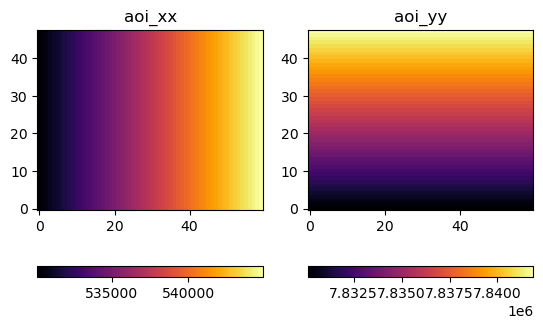

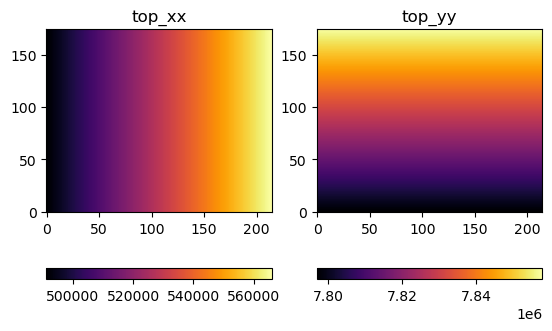

In [6]:
# AREA OF INTEREST GRID
aoi_nx = int((xmax-xmin)/dx)
aoi_ny = int((ymax-ymin)/dy)
aoi_nz = int((zmax-zmin)/dz)
aoi_vx = np.linspace(xmin+dx/2,xmax-dx/2,aoi_nx,endpoint=True)
aoi_vy = np.linspace(ymin+dy/2,ymax-dy/2,aoi_ny,endpoint=True)
aoi_vz = np.linspace(zmin+dz/2,zmax-dz/2,aoi_nz,endpoint=True)
aoi_xx,aoi_yy = np.meshgrid(aoi_vx,aoi_vy,indexing='xy')
# aoi_yy = np.flipud(aoi_yy)
aoi_pts = np.array([aoi_xx.flatten(),aoi_yy.flatten()]).T
if plot:
    check_plot_2_sections(aoi_xx,aoi_yy,'aoi_xx','aoi_yy')

# LOAD INTERFACES
top_basement =  np.load(top_basement_fn)
top_weathered_basement =  np.load(top_weathered_basement_fn)
top_deltaic_sediments =  np.load(top_deltaic_sediments_fn)
# GET INTERFACES DIMENSIONS
top_nx = len(np.unique(top_basement[:,0]))
top_ny = len(np.unique(top_basement[:,1]))
# GET INTERFACES X & Y COORDINATES
top_xx = np.flipud(np.reshape(top_basement[:,0],(top_ny,top_nx)))
top_yy = np.flipud(np.reshape(top_basement[:,1],(top_ny,top_nx)))
if plot:
    check_plot_2_sections(top_xx,top_yy,'top_xx','top_yy')
# RESHAPE INTERFACES AS 2D ARRAYS
zz_top_basement = np.flipud(np.reshape(top_basement[:,-1],(top_ny,top_nx)))
zz_top_weathered_basement = np.flipud(np.reshape(top_weathered_basement[:,-1],(top_ny,top_nx)))
zz_top_deltaic_sediments = np.flipud(np.reshape(top_deltaic_sediments[:,-1],(top_ny,top_nx)))
# ESTIMATE INTERFACES MASK
mask = zz_top_basement< zz_top_basement.max()
# APPLY MASK TO REMOVE MAX PLATEAU VALUES
zz_top_basement[mask==False]=np.nan
zz_top_weathered_basement[mask==False]=np.nan
zz_top_deltaic_sediments[mask==False]=np.nan


# ESTIMATE RESOLUTION
xc_min = top_basement[:,0].min()
xc_max = top_basement[:,0].max()
top_dx = (xc_max-xc_min)/(top_nx-1)
yc_min = top_basement[:,1].min()
yc_max = top_basement[:,1].max()
top_dy = (yc_max-yc_min)/(top_ny-1)
# INDEX OF INTERFACES IMAGES TO SELECT TO BUILD INTERPOLATOR
ix_select = (np.where(
    (top_xx >= xmin-top_dx) & (top_xx <= xmax+top_dx) &
    (top_yy >= ymin-top_dy) & (top_yy <= ymax+top_dy)
))
top_vx = np.sort(np.unique(top_xx[ix_select]))
top_vy = np.sort(np.unique(top_yy[ix_select]))
# print('len vx: '+str(len(top_vx)))
# print('len vy: '+str(len(top_vy)))

In [7]:
ori_top_basement = np.reshape(zz_top_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_weathered_basement = np.reshape(zz_top_weathered_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_deltaic_sediments = np.reshape(zz_top_deltaic_sediments[ix_select],(len(top_vy),len(top_vx)))

# DEFINE INTERPOLATORS
# # flip on y axis because of increasing vy
# data_tbt = np.flipud(ori_top_basement)
# data_twb = np.flipud(ori_top_weathered_basement)
# data_tds = np.flipud(ori_top_deltaic_sediments)

interp_top_basement = RegularGridInterpolator((top_vy, top_vx),ori_top_basement)
interp_top_weathered_basement = RegularGridInterpolator((top_vy, top_vx), ori_top_weathered_basement)
interp_top_deltaic_sediments = RegularGridInterpolator((top_vy, top_vx), ori_top_deltaic_sediments)

aoi_pts = np.array([aoi_yy.flatten(),aoi_xx.flatten()]).T

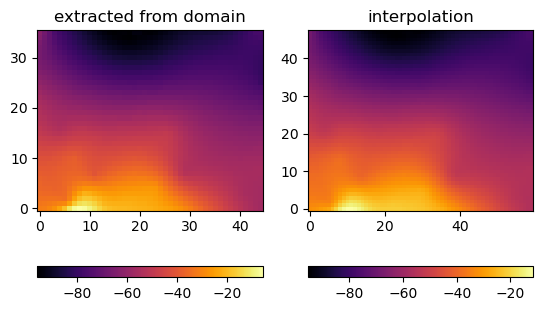

In [8]:
aoi_top_basement = np.reshape(interp_top_basement(aoi_pts),(aoi_ny,aoi_nx))

if plot:
    check_plot_2_sections(ori_top_basement,aoi_top_basement,'extracted from domain','interpolation')

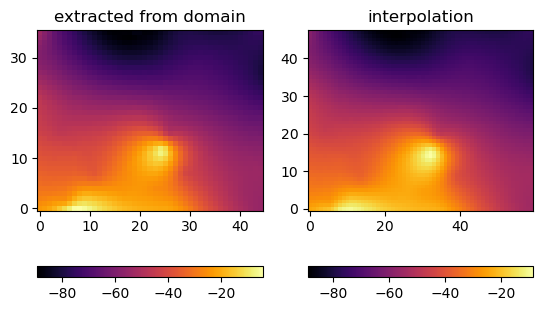

In [9]:
aoi_top_weathered_basement = np.reshape(interp_top_weathered_basement(aoi_pts),(aoi_ny,aoi_nx))

if plot:
    check_plot_2_sections(ori_top_weathered_basement,aoi_top_weathered_basement,'extracted from domain','interpolation')

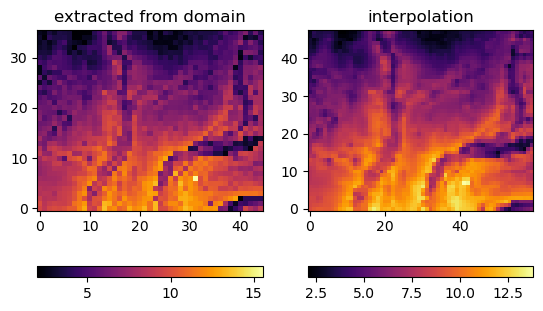

In [10]:
aoi_top_deltaic_sediments = np.reshape(interp_top_deltaic_sediments(aoi_pts),(aoi_ny,aoi_nx))

if plot:
    check_plot_2_sections(ori_top_deltaic_sediments,aoi_top_deltaic_sediments,'extracted from domain','interpolation')

## Building a facies model

In [11]:
#%%############################################################################
# OBJECT BASE MODEL
###############################################################################
printtimelogwithstarline('OBJECT BASE MODEL')
# CREATE GRID
zzz,yyy,xxx = np.meshgrid(aoi_vz,aoi_vy,aoi_vx,indexing='ij')

# CREATE AQUIFER MASK
# 0 basement
# 1 aquifer domain
# np.nan above topography
tmp_twb = np.tile(np.reshape(aoi_top_weathered_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
tmp_tds = np.tile(np.reshape(aoi_top_deltaic_sediments,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
mask_aquifer = np.zeros((aoi_nz,aoi_ny,aoi_nx))
ix_aq = np.where((zzz>=tmp_twb)&(zzz<=tmp_tds))
mask_aquifer[ix_aq] = 1
ix_air = np.where(zzz>tmp_tds)
mask_aquifer[ix_air] = np.nan

# GENERATE TRUNCATED ELLIPSOID PARAMS FOR SAND LENSES AND CLAY LENSES
printtimelog('generate lense params')
lenseClassesList = [sandLenses,clayLenses]
Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies = gen_concatenated_lenses_params(lenseClassesList,mask_aquifer,dx,dz,lbdseed+3)

# GENERATE OBJECT BASED MODELS
printtimelog('generate object based model')
facies_mx,relative_youth_mx = gen_facies_youth_mx(aoi_vx,aoi_vy,aoi_vz,Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies,mask_aquifer)

# ADD DISTINCTION BETWEEN BASEMENT AND WEATHERED BASEMENT
printtimelog('diffrentiat ebasement from weathered basement')
tmp_twt = np.tile(np.reshape(aoi_top_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
ix_bst = np.where(zzz<tmp_twt)
facies_mx[ix_bst]=-1



**********************************************************************
02-Dec-2024 (10:05:13) - OBJECT BASE MODEL
**********************************************************************
02-Dec-2024 (10:05:13) - generate lense params
02-Dec-2024 (10:05:13) - generate object based model
02-Dec-2024 (10:05:13) - diffrentiat ebasement from weathered basement


## Getting model 1-point statistics: proportions and ECDFs

02-Dec-2024 (10:05:13) - load LBD 1-point statistics
02-Dec-2024 (10:05:13) - compute proportions
            count  proportion        labels
lithocodes                                 
1           76347       43.81  intermediate
2           58554       33.60          sand
3           39376       22.59          clay
02-Dec-2024 (10:05:13) - extract thicknesses
**********************************************************************
02-Dec-2024 (10:05:14) - COMPUTE ECDFs
**********************************************************************
02-Dec-2024 (10:05:14) - normalize ecdfs


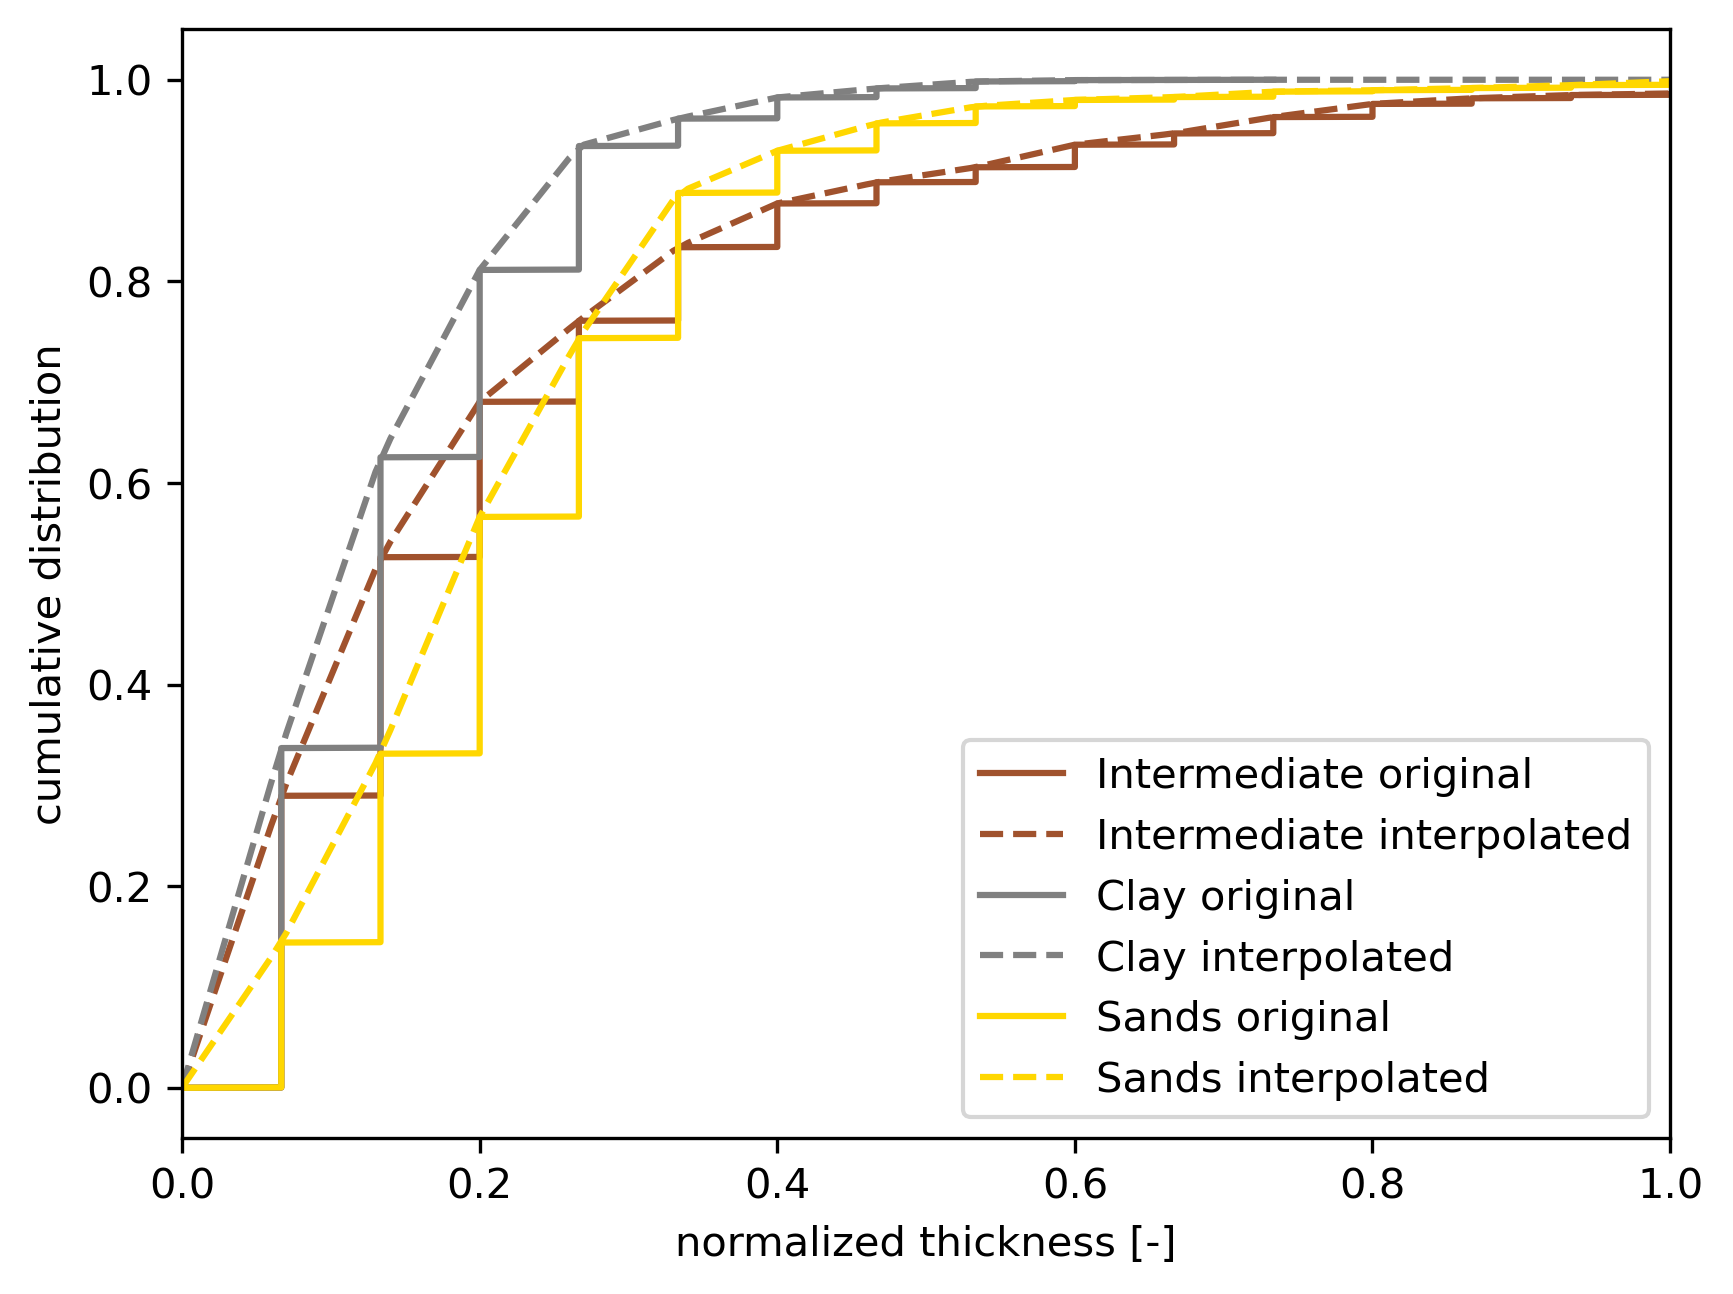

In [12]:
printtimelog('load LBD 1-point statistics')
f = open(ref_err_fn, 'rb')
[prop_clay_mean_p5_p95, prop_sand_mean_p5_p95, prop_inte_mean_p5_p95,
 prop_clay_err_mean_p5_p95, prop_sand_err_mean_p5_p95, prop_inte_err_mean_p5_p95,
 ecdf_clay_mean_p5_p95, ecdf_sand_mean_p5_p95, ecdf_inte_mean_p5_p95, x01_vec, thickness_lim,
 ecdf_clay_area_err_mean_p5_p95, ecdf_sand_area_err_mean_p5_p95, ecdf_inte_area_err_mean_p5_p95] = pickle.load(f)
f.close()
nbins = len(x01_vec)-1
xlim = thickness_lim[1]

# COMPUTE COUNT AND PROPORTIONS PER LITHOCODE
printtimelog('compute proportions')
prop = get_facies_prop(facies_mx,mask_aquifer,lithocodes[2:],labels[2:])
print(prop)

# GET THICKNESSES
printtimelog('extract thicknesses')
df_model_thickness = get_model_litho_thickness(facies_mx,ndhsamples,aoi_nx,aoi_ny,lithocodes,zmin,dz,rng)

# COMPUTE EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS OF THICKNESS PER LITHOCODE
printtimelogwithstarline('COMPUTE ECDFs')
x_clay, ecdf_clay = get_ecdf(df_model_thickness,3)
x_sand, ecdf_sand = get_ecdf(df_model_thickness,2)
x_inte, ecdf_inte = get_ecdf(df_model_thickness,1)

printtimelog('normalize ecdfs')

ecdf01_clay = interp_ecdf_normalize_x(x_clay,ecdf_clay,xlim,x01_vec)
ecdf01_sand = interp_ecdf_normalize_x(x_sand,ecdf_sand,xlim,x01_vec)
ecdf01_inte = interp_ecdf_normalize_x(x_inte,ecdf_inte,xlim,x01_vec)

if plot:
    plt.figure(dpi=300)
    plt.plot(x_inte/xlim, ecdf_inte,'-',color=lithocolors[-3],label='Intermediate original')
    plt.plot(x01_vec, ecdf01_inte,'--',color=lithocolors[-3],label='Intermediate interpolated')
    plt.plot(x_clay/xlim, ecdf_clay,'-',color=lithocolors[-1],label='Clay original')
    plt.plot(x01_vec, ecdf01_clay,'--',color=lithocolors[-1],label='Clay interpolated')
    plt.plot(x_sand/xlim, ecdf_sand,'-',color=lithocolors[-2],label='Sands original')
    plt.plot(x01_vec, ecdf01_sand,'--',color=lithocolors[-2],label='Sands interpolated')
    plt.xlabel('normalized thickness [-]')
    plt.ylabel('cumulative distribution')
    plt.xlim([0,1])
    plt.legend()
    plt.show()


In [13]:
# x = x_clay
# _, indices_x = np.unique(x, return_index=True)
# print(indices_x)
# indices_2=np.concatenate(((indices_x[1:]-1).flatten(),np.array(len(x)-1).flatten()))
# print(indices_2)

# ecdf = ecdf_clay
# print(ecdf[indices_2])

# x_avg = (x[indices_x]+x[indices_2])/2
# # np.concatenate((np.array(thickness_lim[0]).flatten(),
# #                         (x[indices_x]+x[indices_2])/2,
# #                         np.array(thickness_lim[1]).flatten()))

# ecdf_avg = (ecdf[indices_x]+ecdf[indices_2])/2

# x_av2 = np.concatenate((np.array(0).flatten(),(x[indices_x[1:]]+x[indices_2[:-1]])/2,np.array(x.max()).flatten()))
# ecdf_av2 = np.concatenate((np.array(0).flatten(),(ecdf[indices_x[1:]]+ecdf[indices_2[:-1]])/2,np.array(1).flatten()))

# # PREFERRED: max-ecdf-linear

# plt.figure(dpi=300)
# plt.plot(x/xlim,ecdf,label='original')
# plt.plot(x01_vec,ecdf01_clay,'-k',label='interpolated normalized')

# plt.plot(x[indices_x]/xlim,ecdf[indices_x],'--',label='min-ecdf linear')
# plt.plot(x[indices_2]/xlim,ecdf[indices_2],':',label='max-ecdf linear')
# plt.plot(x_avg/xlim,ecdf_avg,'+--',label='avg linear')
# plt.plot(x_av2/xlim,ecdf_av2,'x:',label='av2 linear')
# plt.legend()
# plt.show()

## Computing error and distance to LBD dataset

In [14]:
printtimelogwithstarline('COMPUTE DISTANCE TO LBD DATASET')


printtimelog('compute errors')
err_prop_clay = (float(prop.loc[3,'proportion'])/100-prop_clay_mean_p5_p95[0]) # / prop_clay_err_mean_p5_p95[0]
err_prop_sand = (float(prop.loc[2,'proportion'])/100-prop_sand_mean_p5_p95[0]) #/ prop_sand_err_mean_p5_p95[0]
# err_ratio_prop_inte = (float(prop.loc[1,'proportion'])/100-prop_inte_mean_p5_p95[0]) #/ prop_inte_err_mean_p5_p95[0]

err_ecfd_clay,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_clay_mean_p5_p95[:,0],x01_vec,ecdf01_clay,nbins=nbins) #/ ecdf_clay_area_err_mean_p5_p95[0]
err_ecfd_sand,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_sand_mean_p5_p95[:,0],x01_vec,ecdf01_sand,nbins=nbins) #/ ecdf_sand_area_err_mean_p5_p95[0]
# err_ratio_ecfd_inte,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_inte_mean_p5_p95[:,0],x01_vec,ecdf01_inte,nbins=nbins) #/ ecdf_inte_area_err_mean_p5_p95[0]

printtimelog('compute distance')
errors = np.abs(np.array([err_prop_clay,err_prop_sand,err_ecfd_clay,err_ecfd_sand]))
print('errors: '+str(errors))

dist2lbd = 1 - np.prod(1-errors)**(1/len(errors))
print('dist2lbd: '+str(dist2lbd))


**********************************************************************
02-Dec-2024 (10:05:14) - COMPUTE DISTANCE TO LBD DATASET
**********************************************************************
02-Dec-2024 (10:05:14) - compute errors
02-Dec-2024 (10:05:14) - compute distance
errors: [0.04886289 0.0003008  0.02920153 0.03156975]
dist2lbd: 0.027639125921024355


In [15]:
1-dist2lbd

0.9723608740789756

## View model sections

02-Dec-2024 (10:05:14) - plotting sections - facies


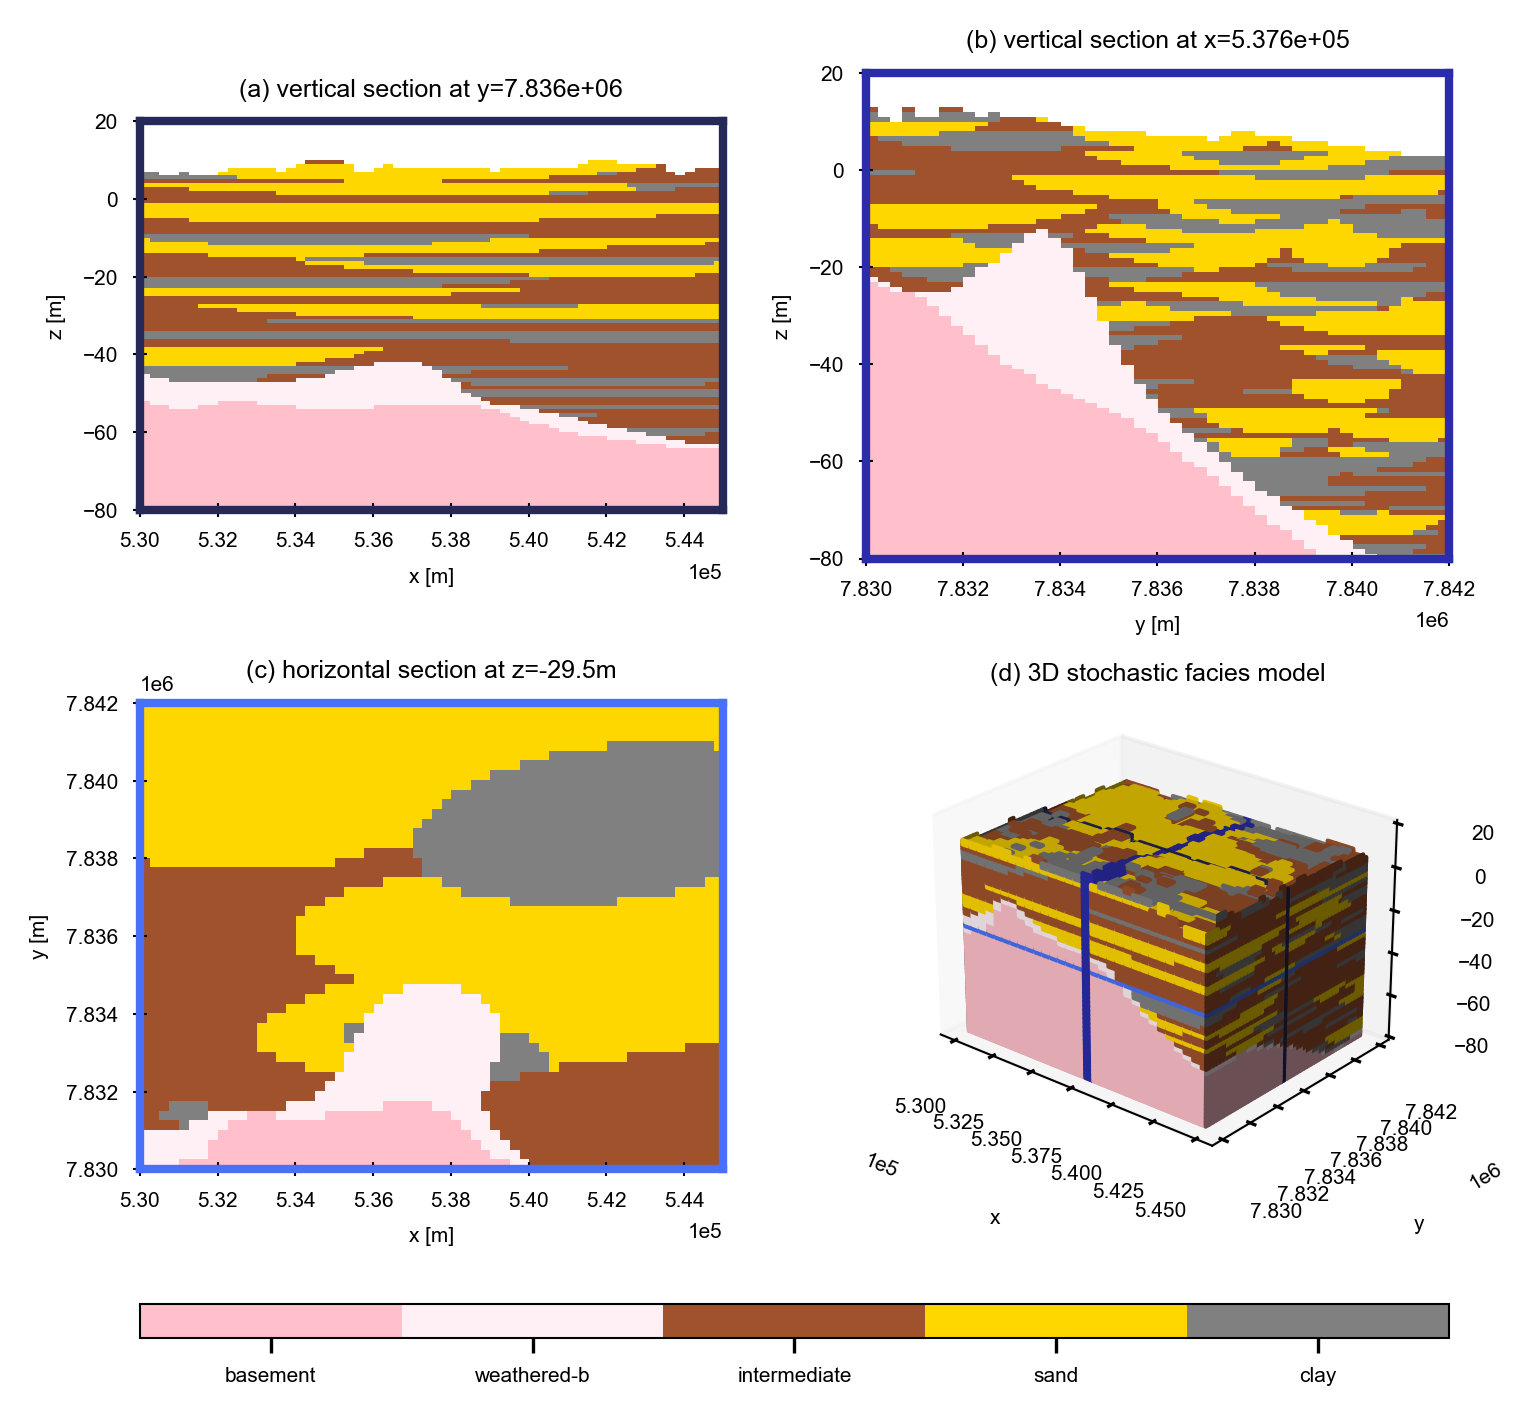

In [16]:
if plot:
    printtimelog('plotting sections - facies')
    # check plot of sections
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(lithocolors) # lavenderblush
    ix,iy,iz=30,22,50
    # FACIES PLOT
    plot3sections(facies_mx,ix,iy,iz,cmap,aoi_vx,aoi_vy,aoi_vz,labeltype='facies',
                  figsize=(15/2.54,12/2.54),fontsize=5,figFileName='../figures/fig8_3Dmodel_facies.png')

02-Dec-2024 (10:05:24) - plotting sections - age


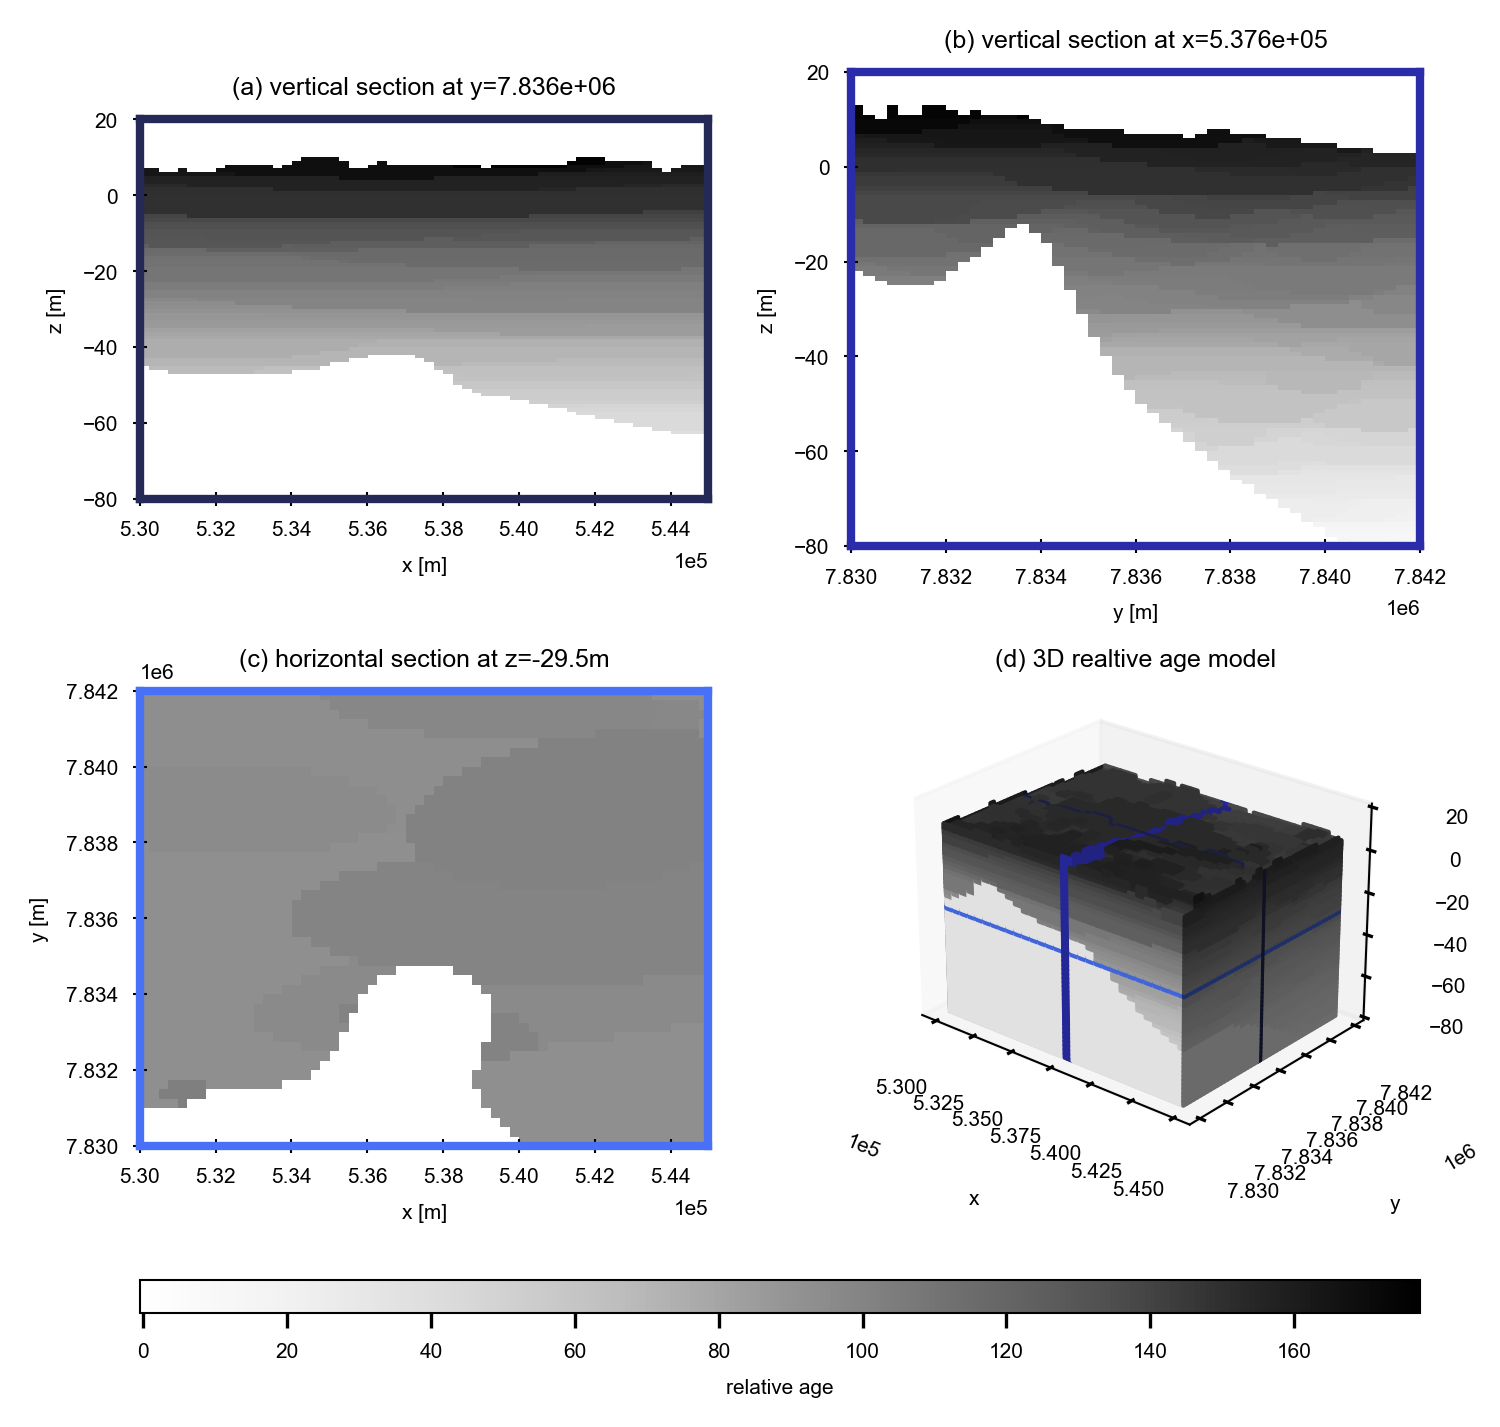

In [17]:
if plot:
    printtimelog('plotting sections - age')
    # YOUTH PLOT (-AGE)
    plot3sections(relative_youth_mx,ix,iy,iz,'Greys',aoi_vx,aoi_vy,aoi_vz,labeltype='age',
                  figsize=(15/2.54,12/2.54),fontsize=5,figFileName='../figures/fig9_3Dmodel_age.png')


In [18]:
printtimelogwithstarline('FINISHED')


**********************************************************************
02-Dec-2024 (10:05:34) - FINISHED
**********************************************************************


In [19]:
print('[aoi_nx,aoi_ny,aoi_nz]: ',[aoi_nx,aoi_ny,aoi_nz])
print('np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]).shape',np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]).shape)

numpy_array = np.copy(facies_mx) #np.copy(np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]))
# [nx,ny,nz]=numpy_array.shape
# print('[nx,ny,nz]: ', [nx,ny,nz])
print('np.unique(numpy_array): ', np.unique(numpy_array))

numpy_array[np.isnan(numpy_array)] = -2 
np.savetxt('tmp_data.txt', numpy_array.flatten(), fmt='%i', delimiter=' ')
print('np.unique(numpy_array): ', np.unique(numpy_array))

# # Read in the file
# with open('tmp_data.txt', 'r') as file:
#   filedata = file.read()

# # Replace the target string
# filedata = filedata.replace('-2', 'NaN')

# # Write the file out again
# with open('tmp_data.txt', 'w') as file:
#   file.write(filedata)

[aoi_nx,aoi_ny,aoi_nz]:  [60, 48, 100]
np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]).shape (60, 48, 100)
np.unique(numpy_array):  [-1.  0.  1.  2.  3. nan]
np.unique(numpy_array):  [-2. -1.  0.  1.  2.  3.]


In [20]:
f = open('tmp_header.txt','w') # change your vtk file name
f.write('# vtk DataFile Version 2.0\n')
f.write('test\n')
f.write('ASCII\n')
f.write('DATASET STRUCTURED_POINTS\n')
f.write('DIMENSIONS '+str(aoi_nx)+' '+str(aoi_ny)+' '+str(aoi_nz)+'\n') # change your dimension
f.write('SPACING '+str(float(dx))+' '+str(float(dy))+' '+str(float(dz))+'\n')
f.write('ORIGIN '+str(float(aoi_vx[0]))+' '+str(float(aoi_vy[0]))+' '+str(float(aoi_vz[0]))+'\n')
f.write('POINT_DATA '+str(int(np.prod(aoi_nx*aoi_ny*aoi_nz)))+'\n') # change the number of point data
f.write('SCALARS facies float 1\n')
f.write('LOOKUP_TABLE default\n')
f.close()

In [21]:
with open(output_fd+'test.vtk','wb') as wfd:
    for f in ['tmp_header.txt','tmp_data.txt']:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)

os.remove('tmp_data.txt')
os.remove('tmp_header.txt')

In [22]:

# Dimensions 
ncells = aoi_nx * aoi_ny * aoi_nz 

npoints = (aoi_nx + 1) * (aoi_ny + 1) * (aoi_nz + 1) 

# Point Coordinates 
pts_vx = np.linspace(xmin,xmax,aoi_nx+1,endpoint=True)
pts_vy = np.linspace(ymin,ymax,aoi_ny+1,endpoint=True)
pts_vz = np.linspace(zmin,zmax,aoi_nz+1,endpoint=True)

z,y,x = np.meshgrid(pts_vz,pts_vy,pts_vx,indexing='ij')

# Variables 

# pressure = np.random.rand(ncells).reshape( (nx, ny, nz)) 

# temp = np.random.rand(npoints).reshape( (nx + 1, ny + 1, nz + 1)) 

gridToVTK(output_fd+"./structured", x, y, z, cellData = {"facies" : numpy_array}) #, pointData = {"temp" : temp}

'C:\\Users\\00102908\\my-UWA\\LowerBurdekinDelta\\notebooks\\structured.vts'

In [23]:
print('zzz.shape :',zzz.shape)

zzz.shape : (100, 48, 60)


In [24]:
numpy_array.shape

(100, 48, 60)